<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [47]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [48]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [49]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [50]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [51]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [52]:
def get_weights():
  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1



  weights[1] *= 2.0
  weights[3] *= 2.0
  weights[4] *= 2.0


  weights = weights / weights.sum()


  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4])

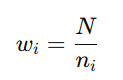

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [53]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [54]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 3:
    googlenet = models.googlenet(weights="IMAGENET1K_V1")
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 6:
    # alexnetmulticlass = models.alexnet(weights=None)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Linear(9216, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(),
    # torch.nn.Linear(512, 7),  # Ja que tenim 7 classes.
    # nn.Softmax(dim=1)
    # )
    # loss_fn = nn.CrossEntropyLoss()

    # return alexnetmulticlass,loss_fn
    return




In [55]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [56]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
        target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
        target = target.to(device)


        input_img = input_img.to(device)
        output = model(input_img.to(device))

        loss = loss_fn(output, target.float())

        output = torch.sigmoid(output)

        output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,zero_division=1)
        train_recall += recall_score(target,output,zero_division=1)
        train_precision += precision_score(target,output,zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [57]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):
            input_img = input_img.to(device)


            target = torch.unsqueeze(target, 1)
            target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
            target = target.to(device)

            output = model(input_img)
            loss = loss_fn(output, target.float())

            output = torch.sigmoid(output)
            output = (output.cpu().detach().numpy() > 0.5).astype(int)
            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,zero_division=1)
            val_recall += recall_score(target,output,zero_division=1)
            val_precision += precision_score(target,output,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [58]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)
  architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet'}


  patiente = 100
  best_recall = 0
  best_precision = 0
  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)

      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

        # torch.save(model, "my_model.pt")
        # wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if (val_recall > best_recall) and (val_precision > best_precision):
        best_recall = val_recall
        best_precision = val_precision
        epoch_number = epoch
        torch.save(model.state_dict(), 'best_model.pt')


  wandb.finish()
  print(best_recall)
  print(best_precision)
  print(epoch_number)

In [59]:
def test(model,dataloader,weights_dir,loss_fn,device):
  model.load_state_dict(torch.load(weights_dir))
  test_acc,test_f1,test_recall,test_precision,test_loss  = validate(model,loss_fn,dataloader,device)

  if WEIGHTSANDBIASES:
    test_metrics = {"test/test_loss": test_loss/len(dataloader),
                      "test/test_acc":test_acc/len(dataloader),
                      "test/test_f1":test_f1/len(dataloader),
                      "test/test_recall": test_recall/len(dataloader),
                      "test/test_precision": test_precision/len(dataloader)}

    wandb.log({**test_metrics})

In [60]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet': 1,'resnet152':2,'googlenet':3}
MODEL = architectures['googlenet']

TRAINING = 0.75
VALIDATION = 0.15
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
#FINE_TUNING = [None,models.AlexNet_Weights.IMAGENET1K_V1]
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 50
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

#get_weights()
extra = 0.4
WEIGHTS = [get_weights()+extra]

learning_rate  = 1e-5

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-ResnetBinary','Ham1000-Resnet152Binary','Ham10000-GoogleNetBinary']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
  test(model,test_loader,"/content/sample_data/best_model.pt",loss_fn,device)

0    5028
1     835
2     824
3     386
4     245
5     106
6      86
Name: count, dtype: int64
7510
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 50, 'batch_size': 32, 'lr': 1e-05, 'trsize': 235, 'trdist': 0.75, 'vsize': 32, 'vdist': 0.15, 'weights': [1.8229647861576397]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.6767710513256966
Accuracy train epoch: 1  train_acc: 0.6956842359767892
F1 train epoch: 1  train_f1: 0.4852311648507215
Recall train epoch: 1  train_recall: 0.7368319623638775


Pèrdua validació epoch: 1  val_loss: 0.5503965597599745
Accuracy val epoch: 1  val_acc: 0.79140625
F1 val epoch: 1  val_f1: 0.561776450570787
Recall val epoch: 1  val_recall: 0.7905792124542125
Recall val epoch: 1  val_precision: 0.4811344037906537


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.5139877787295808
Accuracy train epoch: 2  train_acc: 0.8145793036750484
F1 train epoch: 2  train_f1: 0.575214554674406
Recall train epoch: 2  train_recall: 0.6958428450981646


Pèrdua validació epoch: 2  val_loss: 0.4647941729053855
Accuracy val epoch: 2  val_acc: 0.8337890625
F1 val epoch: 2  val_f1: 0.5674065729914222
Recall val epoch: 2  val_recall: 0.6543402777777778
Recall val epoch: 2  val_precision: 0.5465097402597403


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.4673163819820323
Accuracy train epoch: 3  train_acc: 0.8320599613152805
F1 train epoch: 3  train_f1: 0.5993777024562214
Recall train epoch: 3  train_recall: 0.7047555045427383


Pèrdua validació epoch: 3  val_loss: 0.4412042386829853
Accuracy val epoch: 3  val_acc: 0.849609375
F1 val epoch: 3  val_f1: 0.6195889682320603
Recall val epoch: 3  val_recall: 0.707760642135642
Recall val epoch: 3  val_precision: 0.5853693181818183


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.443518055753505
Accuracy train epoch: 4  train_acc: 0.8450314313346229
F1 train epoch: 4  train_f1: 0.632835096382294
Recall train epoch: 4  train_recall: 0.7257551904360419


Pèrdua validació epoch: 4  val_loss: 0.42151877051219344
Accuracy val epoch: 4  val_acc: 0.8640625
F1 val epoch: 4  val_f1: 0.6149728332705308
Recall val epoch: 4  val_recall: 0.6405832882395383
Recall val epoch: 4  val_precision: 0.6853298611111112


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.41397489639038737
Accuracy train epoch: 5  train_acc: 0.8539530947775629
F1 train epoch: 5  train_f1: 0.6497027357655777
Recall train epoch: 5  train_recall: 0.7465713364649534


Pèrdua validació epoch: 5  val_loss: 0.4077019551768899
Accuracy val epoch: 5  val_acc: 0.8767578125
F1 val epoch: 5  val_f1: 0.667595741676624
Recall val epoch: 5  val_recall: 0.6788814484126986
Recall val epoch: 5  val_precision: 0.6728918650793652


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.40527607963440265
Accuracy train epoch: 6  train_acc: 0.8576039651837524
F1 train epoch: 6  train_f1: 0.6492478936356154
Recall train epoch: 6  train_recall: 0.7379190077062421


Pèrdua validació epoch: 6  val_loss: 0.3989181462675333
Accuracy val epoch: 6  val_acc: 0.8640625
F1 val epoch: 6  val_f1: 0.6655768068790514
Recall val epoch: 6  val_recall: 0.7480620941558442
Recall val epoch: 6  val_precision: 0.6220677759740261


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.39371926740128943
Accuracy train epoch: 7  train_acc: 0.8623791102514506
F1 train epoch: 7  train_f1: 0.654310465080375
Recall train epoch: 7  train_recall: 0.743155544219374


Pèrdua validació epoch: 7  val_loss: 0.38401226326823235
Accuracy val epoch: 7  val_acc: 0.8740234375
F1 val epoch: 7  val_f1: 0.6524776181565666
Recall val epoch: 7  val_recall: 0.7168718434343435
Recall val epoch: 7  val_precision: 0.6477554563492064


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.3735113109679932
Accuracy train epoch: 8  train_acc: 0.8718085106382979
F1 train epoch: 8  train_f1: 0.678692533450784
Recall train epoch: 8  train_recall: 0.7658032747394448


Pèrdua validació epoch: 8  val_loss: 0.37668874207884073
Accuracy val epoch: 8  val_acc: 0.8787109375
F1 val epoch: 8  val_f1: 0.6695853523518966
Recall val epoch: 8  val_recall: 0.6968592171717173
Recall val epoch: 8  val_precision: 0.6839037698412699


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.3641770959534544
Accuracy train epoch: 9  train_acc: 0.877139748549323
F1 train epoch: 9  train_f1: 0.6892244074715584
Recall train epoch: 9  train_recall: 0.7629079195036641


Pèrdua validació epoch: 9  val_loss: 0.36976774549111724
Accuracy val epoch: 9  val_acc: 0.8755859375
F1 val epoch: 9  val_f1: 0.6625663623549652
Recall val epoch: 9  val_recall: 0.6937353445165946
Recall val epoch: 9  val_precision: 0.6684895833333334


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.3536909220700568
Accuracy train epoch: 10  train_acc: 0.8837886847195358
F1 train epoch: 10  train_f1: 0.7062228559092776
Recall train epoch: 10  train_recall: 0.7836782484654825


Pèrdua validació epoch: 10  val_loss: 0.36057873629033566
Accuracy val epoch: 10  val_acc: 0.8857421875
F1 val epoch: 10  val_f1: 0.6866511326650645
Recall val epoch: 10  val_recall: 0.6750868055555556
Recall val epoch: 10  val_precision: 0.7219065656565656


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.33761682129920795
Accuracy train epoch: 11  train_acc: 0.8846470019342361
F1 train epoch: 11  train_f1: 0.704915250242346
Recall train epoch: 11  train_recall: 0.7818333793865708


Pèrdua validació epoch: 11  val_loss: 0.3513749479316175
Accuracy val epoch: 11  val_acc: 0.892578125
F1 val epoch: 11  val_f1: 0.7052455204109616
Recall val epoch: 11  val_recall: 0.7005512716450216
Recall val epoch: 11  val_precision: 0.7506944444444444


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.32913205915309013
Accuracy train epoch: 12  train_acc: 0.8893737911025145
F1 train epoch: 12  train_f1: 0.7178335752398722
Recall train epoch: 12  train_recall: 0.7910193116576097


Pèrdua validació epoch: 12  val_loss: 0.35459785000421107
Accuracy val epoch: 12  val_acc: 0.8865234375
F1 val epoch: 12  val_f1: 0.6609544877636985
Recall val epoch: 12  val_recall: 0.6698536706349207
Recall val epoch: 12  val_precision: 0.7346027236652238


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.32145397073410925
Accuracy train epoch: 13  train_acc: 0.8934235976789169
F1 train epoch: 13  train_f1: 0.7251305934110097
Recall train epoch: 13  train_recall: 0.798146605167882


Pèrdua validació epoch: 13  val_loss: 0.35517179500311613
Accuracy val epoch: 13  val_acc: 0.88359375
F1 val epoch: 13  val_f1: 0.6886995816683316
Recall val epoch: 13  val_recall: 0.7113219246031747
Recall val epoch: 13  val_precision: 0.7051463293650793


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.31028497181040177
Accuracy train epoch: 14  train_acc: 0.8954303675048356
F1 train epoch: 14  train_f1: 0.7318763859887631
Recall train epoch: 14  train_recall: 0.8122101184867139


Pèrdua validació epoch: 14  val_loss: 0.3425074890255928
Accuracy val epoch: 14  val_acc: 0.890625
F1 val epoch: 14  val_f1: 0.7121296399571362
Recall val epoch: 14  val_recall: 0.7392357642357643
Recall val epoch: 14  val_precision: 0.7257200265012766


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.3058697684014097
Accuracy train epoch: 15  train_acc: 0.8997461315280464
F1 train epoch: 15  train_f1: 0.7432471015385586
Recall train epoch: 15  train_recall: 0.8099868334974717


Pèrdua validació epoch: 15  val_loss: 0.33867038995958865
Accuracy val epoch: 15  val_acc: 0.8931640625
F1 val epoch: 15  val_f1: 0.6967558993294288
Recall val epoch: 15  val_recall: 0.699260461760462
Recall val epoch: 15  val_precision: 0.7223338293650795


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.29891465318963883
Accuracy train epoch: 16  train_acc: 0.9004714700193425
F1 train epoch: 16  train_f1: 0.7479684432628902
Recall train epoch: 16  train_recall: 0.8325069847410272


Pèrdua validació epoch: 16  val_loss: 0.332295399508439
Accuracy val epoch: 16  val_acc: 0.8974609375
F1 val epoch: 16  val_f1: 0.7052611198678345
Recall val epoch: 16  val_recall: 0.6798983134920636
Recall val epoch: 16  val_precision: 0.7447544642857143


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.2946796933387188
Accuracy train epoch: 17  train_acc: 0.9035420696324952
F1 train epoch: 17  train_f1: 0.7506243525922726
Recall train epoch: 17  train_recall: 0.8244687227665952


Pèrdua validació epoch: 17  val_loss: 0.33240726962685585
Accuracy val epoch: 17  val_acc: 0.8953125
F1 val epoch: 17  val_f1: 0.7042536347923177
Recall val epoch: 17  val_recall: 0.7061756819569319
Recall val epoch: 17  val_precision: 0.7448412698412701


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.2876591356827858
Accuracy train epoch: 18  train_acc: 0.9055851063829787
F1 train epoch: 18  train_f1: 0.7593569281656796
Recall train epoch: 18  train_recall: 0.8447384176107581


Pèrdua validació epoch: 18  val_loss: 0.3278773329220712
Accuracy val epoch: 18  val_acc: 0.8935546875
F1 val epoch: 18  val_f1: 0.7161283110272081
Recall val epoch: 18  val_recall: 0.7101787968975469
Recall val epoch: 18  val_precision: 0.753360615079365


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.2691522609680257
Accuracy train epoch: 19  train_acc: 0.913563829787234
F1 train epoch: 19  train_f1: 0.7764641099454067
Recall train epoch: 19  train_recall: 0.8407747925833032


Pèrdua validació epoch: 19  val_loss: 0.317470038542524
Accuracy val epoch: 19  val_acc: 0.9013671875
F1 val epoch: 19  val_f1: 0.726826196142179
Recall val epoch: 19  val_recall: 0.7171626984126985
Recall val epoch: 19  val_precision: 0.7673859126984127


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.26368127496952704
Accuracy train epoch: 20  train_acc: 0.9133824951644101
F1 train epoch: 20  train_f1: 0.7747631890026991
Recall train epoch: 20  train_recall: 0.8505431211814191


Pèrdua validació epoch: 20  val_loss: 0.32068907283246517
Accuracy val epoch: 20  val_acc: 0.892578125
F1 val epoch: 20  val_f1: 0.723615157095227
Recall val epoch: 20  val_recall: 0.7821992243867245
Recall val epoch: 20  val_precision: 0.7080605158730158


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.2548794736253454
Accuracy train epoch: 21  train_acc: 0.9175652804642166
F1 train epoch: 21  train_f1: 0.7884214731271978
Recall train epoch: 21  train_recall: 0.8620831060192763


Pèrdua validació epoch: 21  val_loss: 0.33498371695168316
Accuracy val epoch: 21  val_acc: 0.8974609375
F1 val epoch: 21  val_f1: 0.7111331264195041
Recall val epoch: 21  val_recall: 0.708053751803752
Recall val epoch: 21  val_precision: 0.7737475198412699


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.2511353796466868
Accuracy train epoch: 22  train_acc: 0.9204182785299807
F1 train epoch: 22  train_f1: 0.796156171940018
Recall train epoch: 22  train_recall: 0.8661803444782172


Pèrdua validació epoch: 22  val_loss: 0.32777292910031974
Accuracy val epoch: 22  val_acc: 0.8912109375
F1 val epoch: 22  val_f1: 0.7097438337376419
Recall val epoch: 22  val_recall: 0.7826512896825397
Recall val epoch: 22  val_precision: 0.6988963293650794


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.24878704554223
Accuracy train epoch: 23  train_acc: 0.9210348162475822
F1 train epoch: 23  train_f1: 0.7967303923634211
Recall train epoch: 23  train_recall: 0.8707764575849686


Pèrdua validació epoch: 23  val_loss: 0.3234370183199644
Accuracy val epoch: 23  val_acc: 0.9021484375
F1 val epoch: 23  val_f1: 0.7097871276470348
Recall val epoch: 23  val_recall: 0.7218468163780666
Recall val epoch: 23  val_precision: 0.771825396825397


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.24700483445157395
Accuracy train epoch: 24  train_acc: 0.9204424564796906
F1 train epoch: 24  train_f1: 0.7927574893835352
Recall train epoch: 24  train_recall: 0.8750165791655158


Pèrdua validació epoch: 24  val_loss: 0.31494833854958415
Accuracy val epoch: 24  val_acc: 0.897265625
F1 val epoch: 24  val_f1: 0.6912280677591245
Recall val epoch: 24  val_recall: 0.6896333701021203
Recall val epoch: 24  val_precision: 0.7388212481962483


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.23565560867811772
Accuracy train epoch: 25  train_acc: 0.9254714700193424
F1 train epoch: 25  train_f1: 0.8084702233556066
Recall train epoch: 25  train_recall: 0.8717294525805166


Pèrdua validació epoch: 25  val_loss: 0.30736726336181164
Accuracy val epoch: 25  val_acc: 0.901953125
F1 val epoch: 25  val_f1: 0.7353997768979387
Recall val epoch: 25  val_recall: 0.7382316468253969
Recall val epoch: 25  val_precision: 0.7637276785714286


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.22944730884851294
Accuracy train epoch: 26  train_acc: 0.9295333655705996
F1 train epoch: 26  train_f1: 0.8163938959343172
Recall train epoch: 26  train_recall: 0.8857565720331685


Pèrdua validació epoch: 26  val_loss: 0.3009046136867255
Accuracy val epoch: 26  val_acc: 0.9021484375
F1 val epoch: 26  val_f1: 0.7053112731566682
Recall val epoch: 26  val_recall: 0.7255704365079365
Recall val epoch: 26  val_precision: 0.7243529040404041


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.21330240736616418
Accuracy train epoch: 27  train_acc: 0.933389748549323
F1 train epoch: 27  train_f1: 0.8240826967450123
Recall train epoch: 27  train_recall: 0.8873716590737869


Pèrdua validació epoch: 27  val_loss: 0.28738034213893116
Accuracy val epoch: 27  val_acc: 0.9052734375
F1 val epoch: 27  val_f1: 0.7543863489451726
Recall val epoch: 27  val_recall: 0.7796378968253969
Recall val epoch: 27  val_precision: 0.7634920634920636


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.20698188153353142
Accuracy train epoch: 28  train_acc: 0.9393133462282399
F1 train epoch: 28  train_f1: 0.8425139908872864
Recall train epoch: 28  train_recall: 0.9086752018666913


Pèrdua validació epoch: 28  val_loss: 0.3171832733787596
Accuracy val epoch: 28  val_acc: 0.912109375
F1 val epoch: 28  val_f1: 0.7449689041286373
Recall val epoch: 28  val_recall: 0.7283200306637808
Recall val epoch: 28  val_precision: 0.7908358134920636


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.20845445553038983
Accuracy train epoch: 29  train_acc: 0.9332446808510638
F1 train epoch: 29  train_f1: 0.8239949308653332
Recall train epoch: 29  train_recall: 0.8966903073286059


Pèrdua validació epoch: 29  val_loss: 0.30612154700793326
Accuracy val epoch: 29  val_acc: 0.9052734375
F1 val epoch: 29  val_f1: 0.7215184109410915
Recall val epoch: 29  val_recall: 0.725186011904762
Recall val epoch: 29  val_precision: 0.7417343940781442


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.20054554798184557
Accuracy train epoch: 30  train_acc: 0.9372340425531915
F1 train epoch: 30  train_f1: 0.8376595705562833
Recall train epoch: 30  train_recall: 0.8981018390592863


Pèrdua validació epoch: 30  val_loss: 0.31974287424236536
Accuracy val epoch: 30  val_acc: 0.89296875
F1 val epoch: 30  val_f1: 0.7013889552032935
Recall val epoch: 30  val_recall: 0.7183112026862027
Recall val epoch: 30  val_precision: 0.7196394751082251


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.19151100662160428
Accuracy train epoch: 31  train_acc: 0.9428916827852999
F1 train epoch: 31  train_f1: 0.8498519750675078
Recall train epoch: 31  train_recall: 0.9105704461023614


Pèrdua validació epoch: 31  val_loss: 0.29889298556372523
Accuracy val epoch: 31  val_acc: 0.90234375
F1 val epoch: 31  val_f1: 0.7552114944678086
Recall val epoch: 31  val_recall: 0.8036740169552669
Recall val epoch: 31  val_precision: 0.742063492063492


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.18675278260352765
Accuracy train epoch: 32  train_acc: 0.9416948742746616
F1 train epoch: 32  train_f1: 0.845882382261409
Recall train epoch: 32  train_recall: 0.9095942709772501


Pèrdua validació epoch: 32  val_loss: 0.29331562761217356
Accuracy val epoch: 32  val_acc: 0.90234375
F1 val epoch: 32  val_f1: 0.7390407875947023
Recall val epoch: 32  val_recall: 0.7932663690476192
Recall val epoch: 32  val_precision: 0.7179755140692642


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.183016686569503
Accuracy train epoch: 33  train_acc: 0.9429521276595745
F1 train epoch: 33  train_f1: 0.8500142322928101
Recall train epoch: 33  train_recall: 0.9071163115843971


Pèrdua validació epoch: 33  val_loss: 0.30420032085385174
Accuracy val epoch: 33  val_acc: 0.90703125
F1 val epoch: 33  val_f1: 0.7552959601672837
Recall val epoch: 33  val_recall: 0.8134988275613277
Recall val epoch: 33  val_precision: 0.7441935668498167


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.18564549495882177
Accuracy train epoch: 34  train_acc: 0.9436170212765957
F1 train epoch: 34  train_f1: 0.8524710333296444
Recall train epoch: 34  train_recall: 0.913141362183916


Pèrdua validació epoch: 34  val_loss: 0.29823773028329015
Accuracy val epoch: 34  val_acc: 0.89453125
F1 val epoch: 34  val_f1: 0.7232528549237142
Recall val epoch: 34  val_recall: 0.7929428210678212
Recall val epoch: 34  val_precision: 0.6890252976190477


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.17923467165612159
Accuracy train epoch: 35  train_acc: 0.9463491295938105
F1 train epoch: 35  train_f1: 0.8569147606348433
Recall train epoch: 35  train_recall: 0.9196465473061218


Pèrdua validació epoch: 35  val_loss: 0.3121575484983623
Accuracy val epoch: 35  val_acc: 0.905078125
F1 val epoch: 35  val_f1: 0.7350867417648573
Recall val epoch: 35  val_recall: 0.7751059704184704
Recall val epoch: 35  val_precision: 0.7476810515873016


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.165861665663567
Accuracy train epoch: 36  train_acc: 0.9504110251450677
F1 train epoch: 36  train_f1: 0.8681632004876589
Recall train epoch: 36  train_recall: 0.9269196524515677


Pèrdua validació epoch: 36  val_loss: 0.301793510094285
Accuracy val epoch: 36  val_acc: 0.889453125
F1 val epoch: 36  val_f1: 0.7154689573734659
Recall val epoch: 36  val_recall: 0.8228242243867245
Recall val epoch: 36  val_precision: 0.6802858599733601


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.16949783156209805
Accuracy train epoch: 37  train_acc: 0.9476789168278531
F1 train epoch: 37  train_f1: 0.8650621234667085
Recall train epoch: 37  train_recall: 0.9233778514629579


Pèrdua validació epoch: 37  val_loss: 0.3019316769205034
Accuracy val epoch: 37  val_acc: 0.8984375
F1 val epoch: 37  val_f1: 0.7292238215216157
Recall val epoch: 37  val_recall: 0.7790922619047621
Recall val epoch: 37  val_precision: 0.7123263888888889


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.166056162927379
Accuracy train epoch: 38  train_acc: 0.9490812379110252
F1 train epoch: 38  train_f1: 0.8646201581529642
Recall train epoch: 38  train_recall: 0.9259843111970775


Pèrdua validació epoch: 38  val_loss: 0.3069274405715987
Accuracy val epoch: 38  val_acc: 0.90625
F1 val epoch: 38  val_f1: 0.7480101940701871
Recall val epoch: 38  val_recall: 0.7654333513708514
Recall val epoch: 38  val_precision: 0.7564913385225888


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.15653906680960605
Accuracy train epoch: 39  train_acc: 0.952333172147002
F1 train epoch: 39  train_f1: 0.8686975932810549
Recall train epoch: 39  train_recall: 0.9238905066564647


Pèrdua validació epoch: 39  val_loss: 0.32931377296335995
Accuracy val epoch: 39  val_acc: 0.9080078125
F1 val epoch: 39  val_f1: 0.7441721137022069
Recall val epoch: 39  val_recall: 0.7349555826118327
Recall val epoch: 39  val_precision: 0.7817164606227105


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.15872084870934486
Accuracy train epoch: 40  train_acc: 0.9508704061895552
F1 train epoch: 40  train_f1: 0.8700106241239893
Recall train epoch: 40  train_recall: 0.9298600217749156


Pèrdua validació epoch: 40  val_loss: 0.32811916538048536
Accuracy val epoch: 40  val_acc: 0.908203125
F1 val epoch: 40  val_f1: 0.7393446009399957
Recall val epoch: 40  val_recall: 0.7508804563492063
Recall val epoch: 40  val_precision: 0.7675899621212121


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.15006701473860032
Accuracy train epoch: 41  train_acc: 0.9556576402321084
F1 train epoch: 41  train_f1: 0.8787917784153212
Recall train epoch: 41  train_recall: 0.9398305240858434


Pèrdua validació epoch: 41  val_loss: 0.30123378697317094
Accuracy val epoch: 41  val_acc: 0.9140625
F1 val epoch: 41  val_f1: 0.7635475471703219
Recall val epoch: 41  val_recall: 0.7795105068542568
Recall val epoch: 41  val_precision: 0.7826727092352094


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.1517801376099282
Accuracy train epoch: 42  train_acc: 0.954992746615087
F1 train epoch: 42  train_f1: 0.8709878371401786
Recall train epoch: 42  train_recall: 0.9334044206384635


Pèrdua validació epoch: 42  val_loss: 0.28725775866769254
Accuracy val epoch: 42  val_acc: 0.91015625
F1 val epoch: 42  val_f1: 0.7684272988041374
Recall val epoch: 42  val_recall: 0.8000338203463203
Recall val epoch: 42  val_precision: 0.7658583603896104


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.14135453742235266
Accuracy train epoch: 43  train_acc: 0.9584743713733076
F1 train epoch: 43  train_f1: 0.8900752211733479
Recall train epoch: 43  train_recall: 0.9426441407292474


Pèrdua validació epoch: 43  val_loss: 0.29164178809151053
Accuracy val epoch: 43  val_acc: 0.903125
F1 val epoch: 43  val_f1: 0.7340438889026353
Recall val epoch: 43  val_recall: 0.7905753968253969
Recall val epoch: 43  val_precision: 0.7267118298368299


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.13567234524228472
Accuracy train epoch: 44  train_acc: 0.9622340425531914
F1 train epoch: 44  train_f1: 0.8993769970158223
Recall train epoch: 44  train_recall: 0.946189862147309


Pèrdua validació epoch: 44  val_loss: 0.3013143223943189
Accuracy val epoch: 44  val_acc: 0.91015625
F1 val epoch: 44  val_f1: 0.7557463522996614
Recall val epoch: 44  val_recall: 0.7821406024531026
Recall val epoch: 44  val_precision: 0.7525275072150075


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.133632766883424
Accuracy train epoch: 45  train_acc: 0.9617746615087042
F1 train epoch: 45  train_f1: 0.8942948191015858
Recall train epoch: 45  train_recall: 0.9473664869409549


Pèrdua validació epoch: 45  val_loss: 0.29015782568603754
Accuracy val epoch: 45  val_acc: 0.89921875
F1 val epoch: 45  val_f1: 0.7437128836725226
Recall val epoch: 45  val_recall: 0.81667794011544
Recall val epoch: 45  val_precision: 0.7124088585026085


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.1289568047891272
Accuracy train epoch: 46  train_acc: 0.9622340425531914
F1 train epoch: 46  train_f1: 0.8901284655124039
Recall train epoch: 46  train_recall: 0.9444246533608235


Pèrdua validació epoch: 46  val_loss: 0.31210932886460796
Accuracy val epoch: 46  val_acc: 0.91015625
F1 val epoch: 46  val_f1: 0.7684191211909867
Recall val epoch: 46  val_recall: 0.7806795634920636
Recall val epoch: 46  val_precision: 0.7813740079365081


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.1366350045308788
Accuracy train epoch: 47  train_acc: 0.9609042553191489
F1 train epoch: 47  train_f1: 0.8963403596855336
Recall train epoch: 47  train_recall: 0.947250468207915


Pèrdua validació epoch: 47  val_loss: 0.31883320352062583
Accuracy val epoch: 47  val_acc: 0.898046875
F1 val epoch: 47  val_f1: 0.7417213862526363
Recall val epoch: 47  val_recall: 0.7768477182539683
Recall val epoch: 47  val_precision: 0.7476438492063493


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.12998732360119516
Accuracy train epoch: 48  train_acc: 0.9609163442940039
F1 train epoch: 48  train_f1: 0.8920183899309844
Recall train epoch: 48  train_recall: 0.9500815142304506


Pèrdua validació epoch: 48  val_loss: 0.32460067281499505
Accuracy val epoch: 48  val_acc: 0.89609375
F1 val epoch: 48  val_f1: 0.7189288295446385
Recall val epoch: 48  val_recall: 0.7483225108225109
Recall val epoch: 48  val_precision: 0.7609250992063495


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.12103524313090329
Accuracy train epoch: 49  train_acc: 0.9611823017408123
F1 train epoch: 49  train_f1: 0.8908563058330216
Recall train epoch: 49  train_recall: 0.9398455681434406


Pèrdua validació epoch: 49  val_loss: 0.3146650637499988
Accuracy val epoch: 49  val_acc: 0.9068359375
F1 val epoch: 49  val_f1: 0.7463892558464927
Recall val epoch: 49  val_recall: 0.7563570977633478
Recall val epoch: 49  val_precision: 0.785094246031746


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.11360739287226758
Accuracy train epoch: 50  train_acc: 0.9674202127659575
F1 train epoch: 50  train_f1: 0.9100356706406747
Recall train epoch: 50  train_recall: 0.9560417360417364


Pèrdua validació epoch: 50  val_loss: 0.31999873253516853
Accuracy val epoch: 50  val_acc: 0.89921875
F1 val epoch: 50  val_f1: 0.7399867552682956
Recall val epoch: 50  val_recall: 0.8049107142857143
Recall val epoch: 50  val_precision: 0.7299591901154402


train/train_acc,▁▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train/train_f1,▁▂▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████
train/train_loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train/train_precision,▁▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████
train/train_recall,▂▁▁▂▂▂▃▃▃▃▄▄▄▅▄▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇██████
val/val_acc,▁▃▄▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇████▇▇█▇▇▇
val/val_f1,▁▁▃▃▅▄▅▄▆▄▆▆▆▆▆▆▆▆▆▅▆█▇▆▆▇█▆▇▆▇▇▇██▇█▇▆▇
val/val_loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▂▂▁▁▁▁▂▂▂▂
val/val_precision,▁▂▃▆▅▆▅▆▇▇▇▆▇▇▇▆█▆▇▇▇█▇▆▇▇▆▇▆▆█▇█▇▇▆█▇▇▇
val/val_recall,▇▂▄▁▂▄▃▃▂▃▄▅▃▃▄▆▄▆▄▃▄▄▄▄▇█▇▆█▆▅▅▆▇▇█▆▆▅▇
train/train_acc,0.96742


0.8134988275613277
0.7441935668498167
33


<ipython-input-59-9bf2008f8092>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_dir))


FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/best_model.pt'

In [ ]:
print(training.__len__())